# Baseline

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers

import re
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235938", name="baseline")

parser = argparse.ArgumentParser(description="baseline")
parser.add_argument('--feature_name', default="tokenized_stem", type=str) # reviews or tokenized_stem
parser.add_argument('--max_tokens', default=20000, type=int)
parser.add_argument('--sequence_length', default=200, type=int)
parser.add_argument('--embedding_dim', default=128, type=int)
parser.add_argument('--optimizer', default="adam", type=str) # adam or sgd
parser.add_argument('--loss', default="cc", type=str)
parser.add_argument('--learning_rate', default=0.0003, type=float)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--validation_size', default=0.2, type=float)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

feature_name = args.feature_name
max_tokens = args.max_tokens
sequence_length = args.sequence_length
embedding_dim = args.embedding_dim
optimizer = args.optimizer
loss = args.loss
learning_rate = args.learning_rate
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
validation_size = args.validation_size
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

train = pd.read_csv("data/train_okt.csv")
test = pd.read_csv("data/test_okt.csv")

train.shape, test.shape

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


((25000, 5), (25000, 4))

## Preprocessing

In [2]:
X = train[feature_name]
X_test = test[feature_name]
y = train["target"]

y.value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

In [3]:
label_unique = sorted(np.unique(y))
label_unique = {key : value for key, value in zip(label_unique, range(len(label_unique)))}
y = np.array([label_unique[k] for k in y])

label_unique

{1: 0, 2: 1, 4: 2, 5: 3}

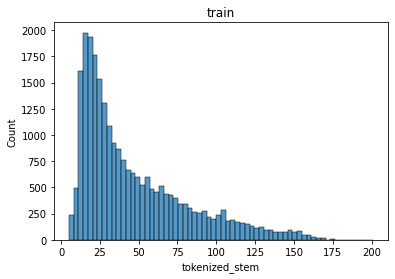

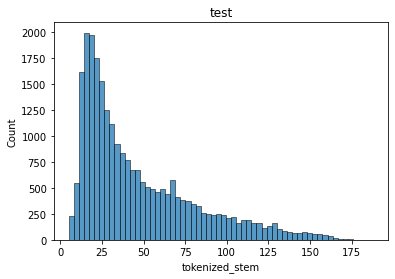

In [4]:
sns.histplot(X.apply(lambda x : len(x)))
plt.title("train")
plt.show()
sns.histplot(X_test.apply(lambda x : len(x)))
plt.title("test")
plt.show()

## Training

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=validation_size, random_state=seed, stratify=y
)

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [6]:
inp = tf.keras.Input(shape=(1,), dtype="string")

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int", output_sequence_length=sequence_length
)
vectorize_layer.adapt(X)
    
x = vectorize_layer(inp)
x = layers.Embedding(
    max_tokens+1, embedding_dim, input_length=sequence_length
)(x)

x = layers.Conv1D(128, 5, 1, padding="valid", activation="relu")(x)
x = layers.Conv1D(128, 5, 1, padding="valid", activation="relu")(x)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(128, 3, 1, padding="valid", activation="relu")(x)
x = layers.Conv1D(128, 3, 1, padding="valid", activation="relu")(x)
x = layers.MaxPooling1D()(x)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)

oup = layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs=inp, outputs=oup)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560128   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          82048     
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 128)          0         
 )                                                           

In [7]:
lr = tf.keras.optimizers.schedules.CosineDecay(learning_rate, decay_steps=1000)
if optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
if loss == "cc":
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    
model.compile(
    optimizer=optim,
    loss=loss_function,
    metrics=["accuracy"]
)

checkpoint_filepath=f"load_model/{parser.description}"

checkpoint_callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, WandbCallback()],
)

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 1.2616 - accuracy: 0.4334

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000024A24935A30>]


157/157 [==============================] - 24s 75ms/step - loss: 1.2616 - accuracy: 0.4334 - val_loss: 1.0588 - val_accuracy: 0.5720 - _timestamp: 1659180801.0000 - _runtime: 48.0000
Epoch 2/100
157/157 [==============================] - 9s 60ms/step - loss: 1.0032 - accuracy: 0.6047 - val_loss: 0.9143 - val_accuracy: 0.6218 - _timestamp: 1659180811.0000 - _runtime: 58.0000
Epoch 3/100
157/157 [==============================] - 9s 60ms/step - loss: 0.8655 - accuracy: 0.6472 - val_loss: 0.8967 - val_accuracy: 0.6324 - _timestamp: 1659180820.0000 - _runtime: 67.0000
Epoch 4/100
157/157 [==============================] - 9s 59ms/step - loss: 0.7946 - accuracy: 0.6691 - val_loss: 0.9148 - val_accuracy: 0.6222 - _timestamp: 1659180830.0000 - _runtime: 77.0000
Epoch 5/100
157/157 [==============================] - 9s 60ms/step - loss: 0.7398 - accuracy: 0.6905 - val_loss: 0.9406 - val_accuracy: 0.6184 - _timestamp: 1659180839.0000 - _runtime: 86.0000
Epoch 6/100
157/157 [====================

In [8]:
model.load_weights(checkpoint_filepath)

## Inference

In [9]:
test_ds = (
    tf.data.Dataset.from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [10]:
pred_prob = model.predict(test_ds)
pred = np.argmax(pred_prob, axis=1)

label_decoder = {val : key for key, val in label_unique.items()}
result = [label_decoder[result] for result in pred]

pd.Series(result).value_counts()

2    12982
5    12017
4        1
dtype: int64

In [11]:
submission = pd.read_csv("data/sample_submission.csv")
submission["target"] = result
submission.to_csv("submission.csv",index=False)